# preparing and training a DNN - architecture

### build on the data prep files:
'2019_07_23_DATA_PREP_3_working_on_big_data_of_GENE_DATA_merging engineering and scaling.ipynb'
'2019_07_23_DATA_PREP_3_working_on_big_data_of_TRAIT_DATA_merging engineering and scaling.ipynb'

### output code into:
'neural_network_1_architecture_sprint_code_2019_07_28.py'


## import and data

In [8]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
#tf.disable_v2_behavior()
from imports2 import *
from tensorflow.keras.layers import Input, Dense, Add, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.losses import cosine_proximity
from keras_lamb import LAMBOptimizer
import keras
from clr2 import LRFinder, OneCycleLR


# -------------------------------
def data_loading(from_date = '2019_07_25'):
    X_train = pd.read_parquet(f'{DATA_DIR}{from_date}_X_train_gene_data.parquet')
    Y_train = pd.read_parquet(f'{DATA_DIR}{from_date}_Y_train_trait_embedding.parquet')
    X_valid = pd.read_parquet(f'{DATA_DIR}{from_date}_X_validation_gene_data.parquet')
    Y_valid = pd.read_parquet(f'{DATA_DIR}{from_date}_Y_validation_trait_embedding.parquet')
    return X_train, Y_train, X_valid, Y_valid

if not 'X_train' in globals():
    X_train, Y_train, X_valid, Y_valid = data_loading()
X_train.shape, Y_train.shape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


((106094, 7576), (106094, 768))

## Architecture

In [16]:
INP_SIZE = X_train.shape[1]
OUT_SIZE = Y_train.shape[1]
LAYERS_SIZE = [1000, 1000, 1000]

def dense_norm_layer(x:'kerasLayer', size:int, batchnorm:bool=True, drop:float=0.3):
    'connect a dense layer, initilized with he_normal and LeakyReLU actication. optinal batchNorm and dropout'
    x = Dense(size, kernel_initializer='he_normal', activation=LeakyReLU())(x)
    if batchnorm: x = BatchNormalization()(x)
    if drop > 0: x = Dropout(drop)(x)    
    return x

def layers_series(x:'kerasLayer', sizes:list, batchnorm:bool=True, drop:float=0.3):
    '''generates a series of layers (dense) based on a list of layers with specific sizes'''
    for size in sizes: x = dense_norm_layer(x, size, batchnorm, drop)
    return x

def add_skip_branch_if_True(x:'layer', inp:'inputLayer', layer_size, skip_branch=True):
    if skip_branch:
        x = Add()([x, dense_norm_layer(inp, layer_size)])
    return x

def Gene_to_trait_model(inp_size:int = INP_SIZE, 
                        layers_size:list = LAYERS_SIZE, 
                        out_size:int = OUT_SIZE,
                        skip_branch:bool = True,
                        optimizer = 'adam',
                        loss='mse'):
    
    '''generate a keras model for trainign gene to trait map'''
    inp = x = Input(shape=(inp_size,))
    
    x = layers_series(x, layers_size)
    x = add_skip_branch_if_True(skip_branch=skip_branch, x = x, inp = inp, layer_size = layers_size[-1])
    out = dense_norm_layer(x, out_size, False, 0)
    
    model = Model(inp, out, name='gene_to_trait')
    model.compile(loss=loss, optimizer=optimizer)
    return model

model = Gene_to_trait_model(optimizer = LAMBOptimizer())
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 7576)         0                                            
__________________________________________________________________________________________________
dense_15 (Dense)                (None, 1000)         7577000     input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_12 (BatchNo (None, 1000)         4000        dense_15[0][0]                   
__________________________________________________________________________________________________
dropout_12 (Dropout)            (None, 1000)         0           batch_normalization_12[0][0]     
__________________________________________________________________________________________________
dense_16 (

# See if it trains ...

In [17]:
x, y = X_train.values, Y_train.values
xv, yv = X_valid.values, Y_valid.values
batch_size = 10000
epochs = 20
model.fit(x,y,batch_size=batch_size, validation_data=[xv, yv], epochs=epochs)

Train on 106094 samples, validate on 342 samples
Epoch 1/20
106094/106094 [==============================] - 24s 228us/step - loss: 2.7103 - val_loss: 0.2513
Epoch 2/20
106094/106094 [==============================] - 22s 205us/step - loss: 1.7814 - val_loss: 0.2477
Epoch 3/20
106094/106094 [==============================] - 22s 205us/step - loss: 1.3295 - val_loss: 0.2825
Epoch 4/20
106094/106094 [==============================] - 22s 205us/step - loss: 1.0668 - val_loss: 0.3368
Epoch 5/20
106094/106094 [==============================] - 22s 205us/step - loss: 0.9002 - val_loss: 0.3911
Epoch 6/20
106094/106094 [==============================] - 22s 204us/step - loss: 0.7889 - val_loss: 0.4633
Epoch 7/20
106094/106094 [==============================] - 22s 206us/step - loss: 0.7158 - val_loss: 0.5516
Epoch 8/20
106094/106094 [==============================] - 22s 205us/step - loss: 0.6655 - val_loss: 0.6322
Epoch 9/20
106094/106094 [==============================] - 22s 205us/step - lo

KeyboardInterrupt: 

# Find a good learning rate range - mse

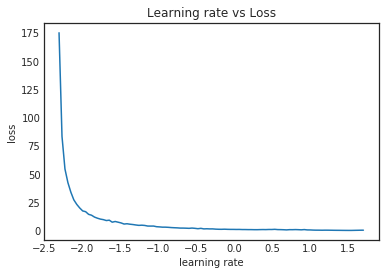

In [42]:
if not os.path.isdir('modeling'): os.mkdir('modeling')
x, y = X_train.values, Y_train.values

def find_lr_cycle(x, y,
                  batch_size = 1024,
                  minimum_lr = 0.005,
                  maximum_lr = 50.0,
                  optimizer='sgd', 
                  loss='mse'
                 ):


    num_samples = len(x)
    lr_callback = LRFinder(num_samples, batch_size, minimum_lr, maximum_lr, 
                          lr_scale='exp', save_dir='modeling',
                          stopping_criterion_factor = None)
    model = Gene_to_trait_model(optimizer=optimizer, loss=loss)
    model.fit(x, y, epochs=1, batch_size=batch_size, callbacks=[lr_callback])
    clear_output()
    lr_callback.plot_schedule()


find_lr_cycle(x, y)

# lr finding - cosine-similarity

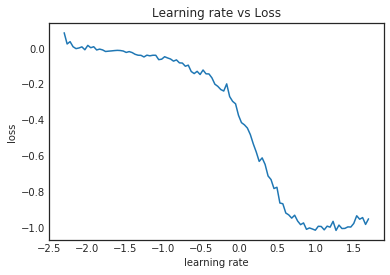

In [43]:
find_lr_cycle(x, y, loss=CosineSimilarity())

# Higher range, smaller batch sizes

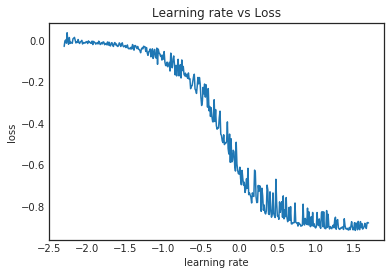

In [44]:
find_lr_cycle(x, y, batch_size = 256, loss=CosineSimilarity())

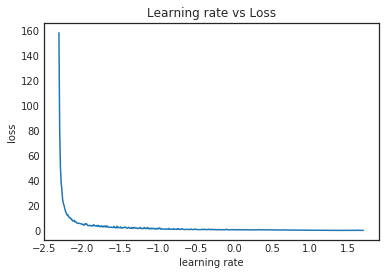

In [45]:
find_lr_cycle(x, y, batch_size = 256, loss='mse')

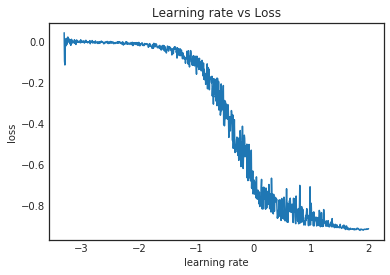

In [36]:
from clr2 import LRFinder, OneCycleLR
num_samples = len(X_train)
batch_size = 128
minimum_lr, maximum_lr = 0.0005, 100.0
if not os.path.isdir('modeling'): os.mkdir('modeling')
lr_callback = LRFinder(num_samples, batch_size, minimum_lr, maximum_lr,
                       lr_scale='exp', save_dir='modeling',
                       stopping_criterion_factor = None)

x, y = X_train.values, Y_train.values
model = Gene_to_trait_model(optimizer='sgd', loss=CosineSimilarity())
model.fit(x, y, epochs=1, batch_size=batch_size, callbacks=[lr_callback])
clear_output()
lr_callback.plot_schedule()

## tf.losses.huber_loss

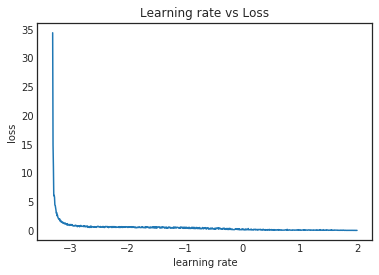

In [47]:
find_lr_cycle(x, y, minimum_lr = 0.0005,  maximum_lr=100.0, batch_size = 128, loss=tf.losses.huber_loss)

In [18]:
INP_SIZE, OUT_SIZE = 7576, 768

(7576, 768)